* data download

In [1]:
#%mkdir data
#%mkdir data/person

#!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00196/ConfLongDemo_JSI.txt
#%mv ConfLongDemo_JSI.txt data/person/

### 1. Prepare analyze
- import module
- data preventing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment

Mounted at /content/drive
/content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment


In [3]:
# Copyright 2021 The ODE-LSTM Authors. All Rights Reserved.
import os
import tensorflow as tf
import argparse
from irregular_sampled_datasets import PersonData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = PersonData()

all_x.shape:  (9711, 32, 7)
all_t.shape:  (9711, 32, 1)
all_y.shape:  (9711, 32)
Total number of sequences: 9711
train_x.shape:  (7769, 32, 7)
train_t.shape:  (7769, 32, 1)
train_y.shape:  (7769, 32)
Total number of train sequences: 7769
Total number of test  sequences: 1942


### 2. Define ODE-LSTM Class

In [5]:
class CTRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, method, num_unfolds=None, tau=1, **kwargs):
        self.fixed_step_methods = {
            "euler": self.euler,
            "heun": self.heun,
            "rk4": self.rk4,
        }
        allowed_methods = ["euler", "heun", "rk4", "dopri5"]
        if not method in allowed_methods:
            raise ValueError(
                "Unknown ODE solver '{}', expected one of '{}'".format(
                    method, allowed_methods
                )
            )
        if method in self.fixed_step_methods.keys() and num_unfolds is None:
            raise ValueError(
                "Fixed-step ODE solver requires argument 'num_unfolds' to be specified!"
            )
        self.units = units
        self.state_size = units
        self.num_unfolds = num_unfolds
        self.method = method
        self.tau = tau
        super(CTRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if isinstance(input_shape[0], tuple):
            # Nested tuple
            input_dim = input_shape[0][-1]

        self.kernel = self.add_weight(
            shape=(input_dim, self.units), initializer="glorot_uniform", name="kernel"
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer="orthogonal",
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(self.units,), initializer=tf.keras.initializers.Zeros(), name="bias"
        )
        self.scale = self.add_weight(
            shape=(self.units,),
            initializer=tf.keras.initializers.Constant(1.0),
            name="scale",
        )
        if self.method == "dopri5":
            # Only load tfp packge if it is really needed
            import tensorflow_probability as tfp

            # We don't need the most precise solver to speed up training
            self.solver = tfp.math.ode.DormandPrince(
                rtol=0.01,
                atol=1e-04,
                first_step_size=0.01,
                safety_factor=0.8,
                min_step_size_factor=0.1,
                max_step_size_factor=10.0,
                max_num_steps=None,
                make_adjoint_solver_fn=None,
                validate_args=False,
                name="dormand_prince",
            )
        self.built = True

    def call(self, inputs, states):
        hidden_state = states[0]
        elapsed = 1.0
        if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
            elapsed = inputs[1]
            # 여기서는 ODE input: h prime
            inputs = inputs[0]

        if self.method == "dopri5":
            # Only load tfp packge if it is really needed
            import tensorflow_probability as tfp

            if not type(elapsed) == float:
                batch_dim = tf.shape(elapsed)[0]
                elapsed = tf.reshape(elapsed, [batch_dim])

                idx = tf.argsort(elapsed)
                solution_times = tf.gather(elapsed, idx)
            else:
                solution_times = elapsed

            hidden_state = states[0]
            res = self.solver.solve(
                ode_fn=self.dfdt_wrapped,
                initial_time=0,
                initial_state=hidden_state,
                solution_times=solution_times,  # tfp.math.ode.ChosenBySolver(elapsed),
                constants={"input": inputs},
            )
            if not type(elapsed) == float:
                i2 = tf.stack([idx, tf.range(batch_dim)], axis=1)
                hidden_state = tf.gather_nd(res.states, i2)
            else:
                hidden_state = res.states[-1]
        else:
            delta_t = elapsed / self.num_unfolds
            method = self.fixed_step_methods[self.method]
            for i in range(self.num_unfolds):
                hidden_state = method(inputs, hidden_state, delta_t)
        return hidden_state, [hidden_state]

    def dfdt_wrapped(self, t, y, **constants):
        inputs = constants["input"]
        hidden_state = y
        return self.dfdt(inputs, hidden_state)

    def dfdt(self, inputs, hidden_state):
        h_in = tf.matmul(inputs, self.kernel)
        h_rec = tf.matmul(hidden_state, self.recurrent_kernel)
        dh_in = self.scale * tf.nn.tanh(h_in + h_rec + self.bias)
        if self.tau > 0:
            dh = dh_in - hidden_state * self.tau
        else:
            dh = dh_in
        return dh

    def euler(self, inputs, hidden_state, delta_t):
        dy = self.dfdt(inputs, hidden_state)
        return hidden_state + delta_t * dy

    def heun(self, inputs, hidden_state, delta_t):
        k1 = self.dfdt(inputs, hidden_state)
        k2 = self.dfdt(inputs, hidden_state + delta_t * k1)
        return hidden_state + delta_t * 0.5 * (k1 + k2)

    def rk4(self, inputs, hidden_state, delta_t):
        k1 = self.dfdt(inputs, hidden_state)
        k2 = self.dfdt(inputs, hidden_state + k1 * delta_t * 0.5)
        k3 = self.dfdt(inputs, hidden_state + k2 * delta_t * 0.5)
        k4 = self.dfdt(inputs, hidden_state + k3 * delta_t)

        return hidden_state + delta_t * (k1 + 2 * k2 + 2 * k3 + k4) / 6.0

In [6]:
class ODELSTM(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        self.ctrnn = CTRNNCell(self.units, num_unfolds=4, method="euler")
        super(ODELSTM, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        input_dim = input_shape[-1]-1
        # if isinstance(input_shape[0], tuple):
        #     # Nested tuple
        #     input_dim = input_shape[0][-1]

        self.ctrnn.build([self.units])
        self.input_kernel = self.add_weight(
            shape=(input_dim, 4 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(4 * self.units,), initializer=tf.keras.initializers.Zeros(),name="bias",
        )

        self.built = True

    def call(self, inputs, states):
        cell_state, ode_state = states
        elapsed = 1.0

        # concat 해서 넣었기 때문에 time elapsed 와 input data를 나눈다.
        # (None, 8) -> (None, 7), (None, 1)
        elapsed = inputs[:,7:]
        inputs = inputs[:,:-1]

        z = (
            tf.matmul(inputs, self.input_kernel)
            + tf.matmul(ode_state, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og = tf.split(z, 4, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        forget_gate = tf.nn.sigmoid(fg + 3.0)
        output_gate = tf.nn.sigmoid(og)

        new_cell = cell_state * forget_gate + input_activation * input_gate

        ode_input = tf.nn.tanh(new_cell) * output_gate
        ode_output, new_ode_state = self.ctrnn.call([ode_input, elapsed], [ode_state])

        return ode_output, [new_cell, new_ode_state[0]]

### 3. Define model

In [24]:
def train_model():
    pixel_input = tf.keras.Input(shape=(data.seq_len, data.feature_size), name="features")
    time_input = tf.keras.Input(shape=(data.seq_len, 1), name="time")

    # concatLayer 정의
    # 저자가 제공하는 lstm 코드에서는 call 부분에서 concat을 진행하였지만 현재 tensorflow rnn이 tuple 형태의 multi-input이 안되어 미리 병합하는 layer를 정의한다.
    class concatLayer(tf.keras.layers.Layer):
        def call(self, x, y):
            concat = tf.concat([x, y], axis=-1)  # (None, seq_len, feature_size + 1)
            return concat  # (None, seq_len, 8)

    # 입력 병합
    inputs = concatLayer()(pixel_input, time_input)
    rnn = tf.keras.layers.RNN(ODELSTM(64), return_sequences=True)
    dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data.num_classes))

    #output_states = rnn((pixel_input, time_input))
    output_states = rnn(inputs)
    y = dense_layer(output_states)

    model = tf.keras.Model(inputs=[pixel_input, time_input], outputs=[y])
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # 모델 훈련 및 평가
    hist = model.fit(
        x=(data.train_x, data.train_t),
        y=data.train_y,
        batch_size=128,
        epochs=200,
        validation_data=((data.test_x, data.test_t), data.test_y),
    )
    _, best_test_acc = model.evaluate(
        x=(data.test_x, data.test_t), y=data.test_y, verbose=2
    )

    return model, hist,best_test_acc

In [25]:
model_1, hist_1, best_test_acc_1 = train_model()
print("1 끝")
model_2, hist_2, best_test_acc_2 = train_model()
print("2 끝")
model_3, hist_3, best_test_acc_3 = train_model()
print("3 끝")
model_4, hist_4, best_test_acc_4 = train_model()
print("4 끝")
model_5, hist_5, best_test_acc_5 = train_model()
print("5 끝")

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - loss: 1.8527 - sparse_categorical_accuracy: 0.3150 - val_loss: 1.6971 - val_sparse_categorical_accuracy: 0.3714
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7054 - sparse_categorical_accuracy: 0.3416 - val_loss: 1.7141 - val_sparse_categorical_accuracy: 0.3715
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6184 - sparse_categorical_accuracy: 0.3885 - val_loss: 1.2060 - val_sparse_categorical_accuracy: 0.5261
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2215 - sparse_categorical_accuracy: 0.5265 - val_loss: 1.0121 - val_sparse_categorical_accuracy: 0.6212
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0052 - sparse_categorical_accuracy: 0.6151 - val_loss: 0.9232 - val_sparse_categorical_accuracy: 0.6265
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8580 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.7370
Epo

In [26]:
def plot_hist(hist):
    # history에서 loss, accuracy 값 추출
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sparse_categorical_accuracy = hist.history['sparse_categorical_accuracy']
    val_sparse_categorical_accuracy = hist.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Loss 그래프
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, sparse_categorical_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_sparse_categorical_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

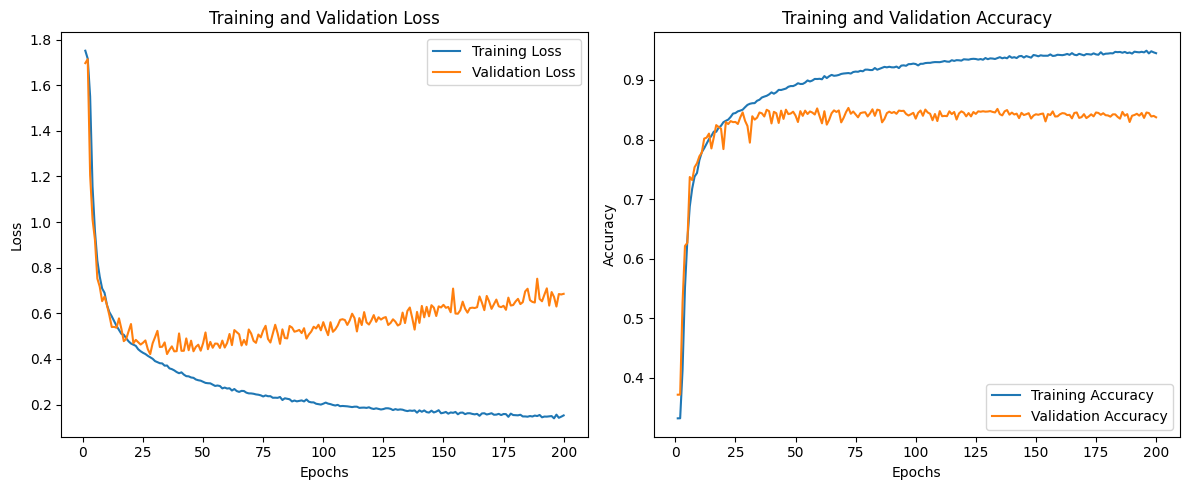

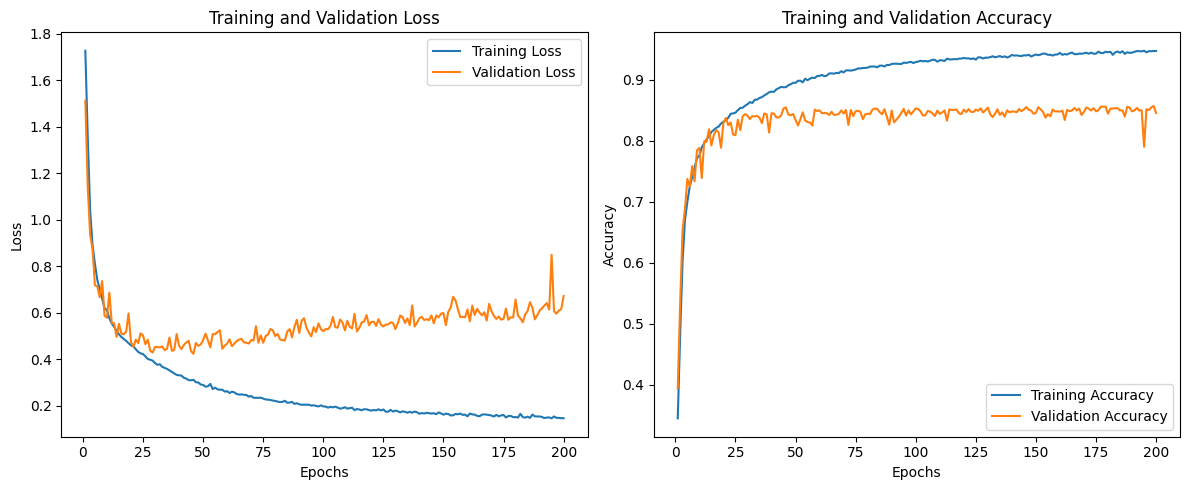

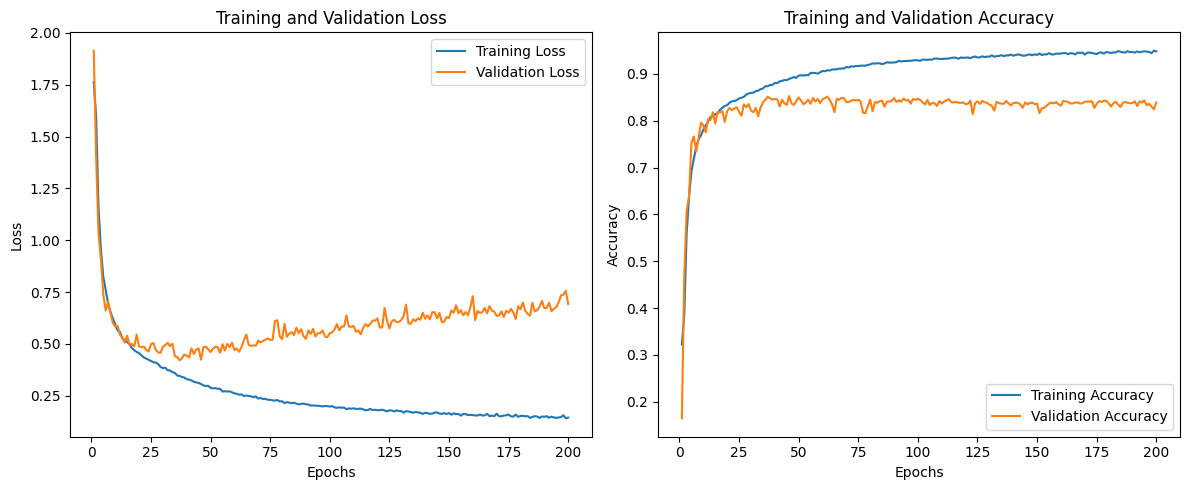

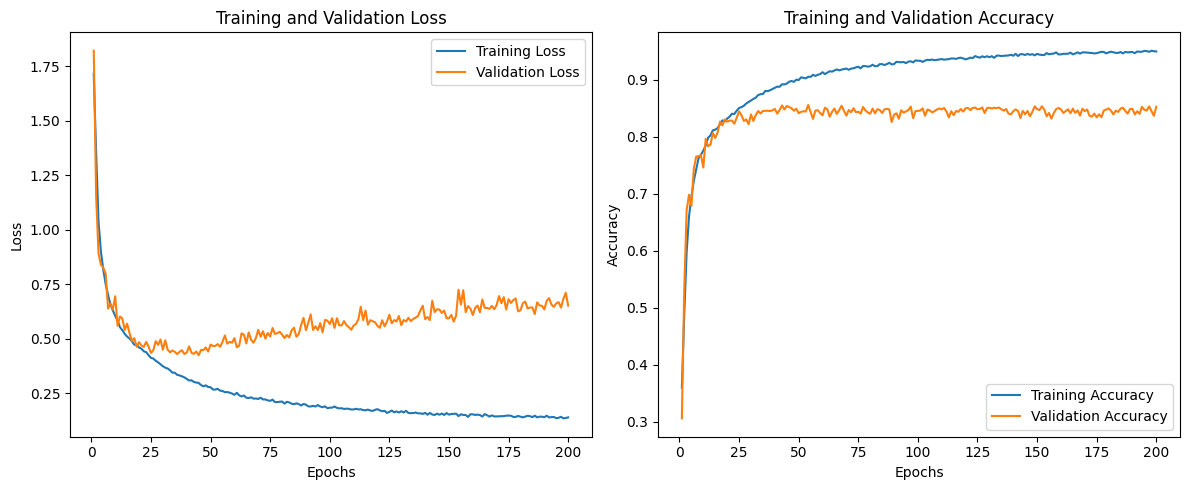

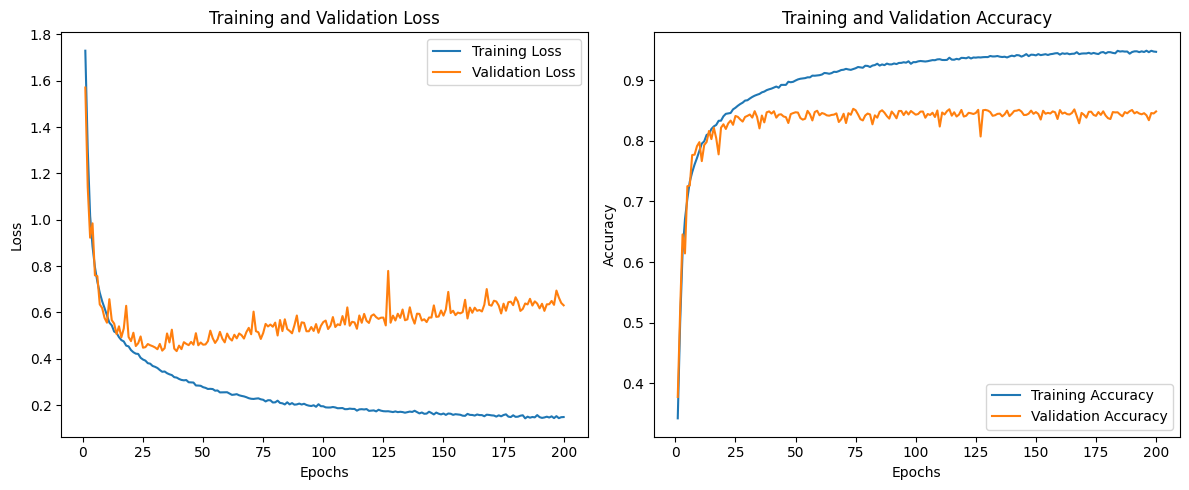

In [27]:
plot_hist(hist_1)
plot_hist(hist_2)
plot_hist(hist_3)
plot_hist(hist_4)
plot_hist(hist_5)

In [31]:
mean = np.mean([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])
std = np.std([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])

print(f"{mean*100}%, {std*100}")

84.46414828300476%, 0.5820131076537921
